# Hypothesis Functionality

## Goals
We want a hypothesis that is:
- Simple. As few nodes as possible.
- Probable. Should have a high probability of being true

## Important Functions
- Write the Graph
- Learn the CPT Table
- ObserveData: Should be done after CPT Table is created but before hypothesis testing
- findBestExplanation given the observed data and the graph

## TO DO:
- add functionality that handles multi-node hypothesis where individual hyps don't explain everything

In [23]:
from similarityfunctions import *
import networkx as nx
from itertools import permutations, combinations

In [14]:
# add observations to a graph
def observeData(graph, true_nodes, false_nodes):
    nodes = graph.nodes()
    for i in nodes:
        if i in true_nodes:
            graph.nodes[i]['value'] = 1
        elif i in false_nodes:
            graph.nodes[i]['value'] = 0
        else:
            graph.nodes[i]['value'] = None

In [15]:
class CPT(object):
    """
    Defines a CPT Class
    """
    def __init__(self, num_parents):
        self.num_parents = num_parents
        self.CPTable = self.make_table()
        
    def make_table(self):
        CPTable = {}
        if self.num_parents > 0:
            for i in range(2**self.num_parents):
                CPTable[bin(i)] = 0.0
        else:
            CPTable['self'] = 0.0
        return CPTable
    
    def add_entry(self, parent_values, prob):
        # values of nodes sorted in alphabetical order
        key = ''
        for i in parent_values:
            key += str(i)
        self.CPTable[bin(int(key, 2))] = prob 
    
    def add_entry_self(self, prob):
        self.CPTable['self'] = prob
    
    def get_entry(self, parent_values, value):
        key = ''
        for i in parent_values:
            key += str(i)
        return self.CPTable[bin(int(key, 2))][value]
    
    def get_entry_bin(self, parent_bin, value):
        return self.CPTable[parent_bin][value]
    
    def get_entry_self(self, value):
        return self.CPTable['self'][value]
    
    def get_table(self):
        return self.CPTable

In [16]:
from itertools import product
def calculateMarginalProbability(blanket, knodes):
    sorted_nodes = sorted(blanket.nodes())
    # want to calculate P(hyp | obs)
    # first, calculate marginal probability of P(hyp, obs, nodes)
    
    unodes = [item for item in sorted_nodes if (not item in knodes)]
    keys = list(product(range(2), repeat=len(unodes)))
    prob = 0
    for i in keys:
        p = 1
        for x in sorted_nodes:
            # find the parent values of a node
            parents = sorted(list(blanket.predecessors(x)))
            # if it has parents, get the key and get the probability
            if parents:
                # get the parents:
                parent_values = []
                for z in parents:
                    if z in knodes:
                        parent_values.append(blanket.node[z]['value'])
                    else:
                        parent_values.append(i[unodes.index(z)])
                
                parents_key = bin(int(''.join(map(str, parent_values)), 2))
                if x in knodes:
                    p *= blanket.node[x]['CPT'].get_entry_bin(parents_key, blanket.node[x]['value'])
                else:
                    p *= blanket.node[x]['CPT'].get_entry_bin(parents_key, i[unodes.index(x)])
            # if it doesn't have parents, get the entry for itself based on the node value
            else:
                if x in knodes:
                    p *= blanket.node[x]['CPT'].get_entry_self(blanket.node[x]['value'])
                else:
                    p *= blanket.node[x]['CPT'].get_entry_self(i[unodes.index(x)])
        prob += p
    return prob

In [17]:
def calculateTotalMarginalProbability(blanket, hyp, obs, bnodes):
    # hyp | obs
    # obs | hyp
    all_obs = []
    all_obs += obs
    all_obs += hyp
    all_obs += bnodes
    new_obs = obs + bnodes
    num_prob = calculateMarginalProbability(blanket, all_obs)
    denom_prob = calculateMarginalProbability(blanket, new_obs)
    return num_prob / denom_prob

def calculateTotalMarginalProbabilityObs(blanket, hyp, obs, bnodes):
    all_obs = []
    all_obs += obs
    all_obs += hyp
    all_obs += bnodes
    new_hyp = hyp + bnodes
    num_prob = calculateMarginalProbability(blanket, all_obs)
    denom_prob = calculateMarginalProbability(blanket, new_hyp)
    return num_prob / denom_prob

In [140]:
# Finds all possible hypothesis
def combinationsList(my_list):
    total = []
    for i in range(1, len(my_list) + 1):
        total += list(combinations(my_list, i))
    return total

def findHypotheses(graph, observed_nodes, bnodes):
    all_node_combos = combinationsList(graph.nodes())
    hyps = []
    for i in all_node_combos:
        children = {}
        for x in i:
            children.update(get_all_children(graph, x, {}, 1))
        if all(item in children.keys() for item in observed_nodes):
            if not any(item in observed_nodes for item in i) and not any(item in bnodes for item in i) :
                hyps.append(list(i))
    return hyps

# Finds a bunch of hypothesis. Does nothing yet
def findBestExplanation(graph, observed_nodes, bnodes, flipped=False):
    hyps = findHypotheses(graph, observed_nodes, bnodes)
    current_best = (None, 0)
    for i in hyps:
        if isinstance(i, list): 
            for x in i:
                graph.nodes[x]['value'] = 1
            if flipped:
                prob = calculateTotalMarginalProbabilityObs(graph, list(i), observed_nodes, bnodes)
            else:
                prob = calculateTotalMarginalProbability(graph, list(i), observed_nodes, bnodes)
            for x in i:
                graph.nodes[x]['value'] = None
        else:
            graph.nodes[i]['value'] = 1
            if flipped:
                prob = calculateTotalMarginalProbabilityObs(graph, list(i), observed_nodes, bnodes)
            else:
                prob = calculateTotalMarginalProbability(graph, list(i), observed_nodes, bnodes)
            graph.nodes[i]['value'] = None
        if prob > current_best[1]:
            current_best = (i, prob)
        print((i, prob))
    return current_best

## Cost Functions
- What do we want to prioritize? 


## Testing

### Burgler Tests
Based off the example found [HERE](https://www.ics.uci.edu/~rickl/courses/cs-171/2012-wq-cs171/2012-wq-cs171-lecture-slides/2012wq171-17-BayesianNetworks.pdf)

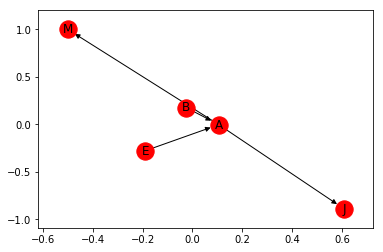

In [141]:
bdg = nx.DiGraph()
bdg.add_nodes_from(['B', 'E', 'A', 'M', 'J'])
bdg.add_weighted_edges_from([('B','A', .94002),('E','A', .29066),('A', 'M',.7),('A','J',.9)])
nx.draw_networkx(bdg)

In [142]:
# learn the CPTable

# burglar
cpt_B = CPT(0)
cpt_B.add_entry_self((1-.001, .001))
bdg.node['B']['CPT'] = cpt_B
# earthquake
cpt_E = CPT(0)
cpt_E.add_entry_self((1-.002, .002))
bdg.node['E']['CPT'] = cpt_E
#alarm
cpt_A = CPT(2)
cpt_A.add_entry([1, 1], (1-.95, .95))
cpt_A.add_entry([1, 0], (1-.94, .94))
cpt_A.add_entry([0, 1], (1-.29, .29))
cpt_A.add_entry([0, 0], (1-.001, .001))
bdg.node['A']['CPT'] = cpt_A
#john calls
cpt_J = CPT(1)
cpt_J.add_entry([1], (1-.9, .9))
cpt_J.add_entry([0], (1-.05, .05))
bdg.node['J']['CPT'] = cpt_J
#mary calls
cpt_M = CPT(1)
cpt_M.add_entry([1], (1-.7, .7))
cpt_M.add_entry([0], (1-.01, .01))
bdg.node['M']['CPT'] = cpt_M

In [143]:
observeData(bdg, ['A', 'M'], [])

In [144]:
findBestExplanation(bdg, ['M', 'A'], [])

(['B'], 0.373551228281836)
(['E'], 0.23100870196889098)
(['B', 'E'], 0.0007550342904783817)
(['B', 'J'], 0.33619610545365236)
(['E', 'J'], 0.2079078317720019)
(['B', 'E', 'J'], 0.0006795308614305436)


(['B'], 0.373551228281836)

In [145]:
findBestExplanation(bdg, ['M', 'A'], [], flipped=True)

(['B'], 0.658014)
(['E'], 0.20346199999999998)
(['B', 'E'], 0.6649999999999999)
(['B', 'J'], 0.6975273757769278)
(['E', 'J'], 0.6164249093620501)
(['B', 'E', 'J'], 0.6979591836734693)


(['B', 'E', 'J'], 0.6979591836734693)

### Sprinkler Tests
Example found [here](https://www.bayesserver.com/examples/networks/sprinkler)

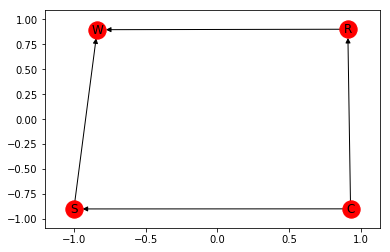

In [146]:
# make the graph
sdg = nx.DiGraph()
sdg.add_nodes_from(['C', 'S', 'R', 'W'])
sdg.add_weighted_edges_from([('C','S', 0),('C','R', 0),('S', 'W', 0),('R','W', 0)])
nx.draw_networkx(sdg)

In [147]:
# learn the CPTable

# Cloudy
cpt_C = CPT(0)
cpt_C.add_entry_self((.5, .5))
sdg.node['C']['CPT'] = cpt_C

# Rain
cpt_R = CPT(1)
cpt_R.add_entry([1], (1-.8, .8))
cpt_R.add_entry([0], (1-.2, .2))
sdg.node['R']['CPT'] = cpt_R

# Sprinkler
cpt_S = CPT(1)
cpt_S.add_entry([1], (1-.1, .1))
cpt_S.add_entry([0], (1-.5, .5))
sdg.node['S']['CPT'] = cpt_S

# Grass Wet
cpt_W = CPT(2)
cpt_W.add_entry([1, 1], (1-.99, .99))
cpt_W.add_entry([1, 0], (1-.9, .9))
cpt_W.add_entry([0, 1], (1-.9, .9))
cpt_W.add_entry([0, 0], (1, 0))
sdg.node['W']['CPT'] = cpt_W

In [148]:
# observe the data
observeData(sdg, ['W', 'C'], [])

In [149]:
# calculate the total marginal probability (both ways)
# hyp | obs
findBestExplanation(sdg, ['W'], ['C'])

(['S'], 0.13043478260869565)
(['R'], 0.9758454106280193)
(['S', 'R'], 0.10628019323671498)


(['R'], 0.9758454106280193)

In [150]:
# obs | hyp
findBestExplanation(sdg, ['W'], ['C'], flipped=True)

(['S'], 0.9720000000000001)
(['R'], 0.909)
(['S', 'R'], 0.9900000000000001)


(['S', 'R'], 0.9900000000000001)

### Asia Tests
Example found [here](https://www.bayesserver.com/examples/networks/asia)

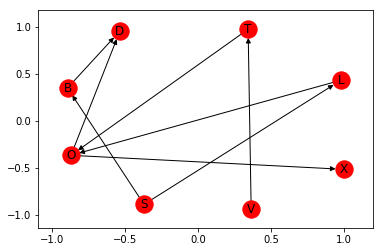

In [151]:
# make the graph
adg = nx.DiGraph()
adg.add_nodes_from(['V', 'T', 'S', 'L', 'B', 'O', 'X', 'D'])
adg.add_weighted_edges_from([('V','T', 0),('T','O', 0),('O','X', 0),
                             ('O','D', 0), ('S','L', 0), ('S','B', 0),
                            ('L','O', 0), ('B','D', 0)])
nx.draw_networkx(adg)

In [152]:
# learn the CPTable

# Visit to Asia
cpt_V = CPT(0)
cpt_V.add_entry_self((.99, .01))
adg.node['V']['CPT'] = cpt_V

# Smoker
cpt_S = CPT(0)
cpt_S.add_entry_self((.5, .5))
adg.node['S']['CPT'] = cpt_S

# Tuburculosis
cpt_T = CPT(1)
cpt_T.add_entry([1], (1-.05, .05))
cpt_T.add_entry([0], (1-.01, .01))
adg.node['T']['CPT'] = cpt_T

# Lung Cancer
cpt_L = CPT(1)
cpt_L.add_entry([1], (1-.1, .1))
cpt_L.add_entry([0], (1-.01, .01))
adg.node['L']['CPT'] = cpt_L

# Bronchitus
cpt_B = CPT(1)
cpt_B.add_entry([1], (1-.6, .6))
cpt_B.add_entry([0], (1-.3, .3))
adg.node['B']['CPT'] = cpt_B

# Tub or Cancer
cpt_O = CPT(2)
cpt_O.add_entry([1, 1], (0, 1))
cpt_O.add_entry([1, 0], (0, 1))
cpt_O.add_entry([0, 1], (0, 1))
cpt_O.add_entry([0, 0], (1, 0))
adg.node['O']['CPT'] = cpt_O

# Dyspena
cpt_D = CPT(2)
cpt_D.add_entry([1, 1], (1-.9, .9))
cpt_D.add_entry([1, 0], (1-.8, .8))
cpt_D.add_entry([0, 1], (1-.7, .7))
cpt_D.add_entry([0, 0], (1-.1, .1))
adg.node['D']['CPT'] = cpt_D

# Xray result
cpt_X = CPT(1)
cpt_X.add_entry([1], (1-.98, .98))
cpt_X.add_entry([0], (1-.05, .05))
adg.node['X']['CPT'] = cpt_X

In [153]:
# observe the data
observeData(adg, ['X'], ['S'])

In [154]:
findBestExplanation(adg, ['X'], ['S'])

(['V'], 0.015293585739324756)
(['T'], 0.14797761983689933)
(['L'], 0.1422861729200955)
(['O'], 0.2887840165586259)
(['V', 'T'], 0.007114308646004777)
(['V', 'L'], 0.0014228617292009551)
(['V', 'B'], 0.004588075721797427)
(['V', 'O'], 0.008466027288745685)
(['V', 'D'], 0.008550723859126233)
(['T', 'L'], 0.0014797761983689935)
(['T', 'B'], 0.044393285951069804)
(['T', 'O'], 0.14797761983689933)
(['T', 'D'], 0.1124629910760435)
(['L', 'B'], 0.042685851876028656)
(['L', 'O'], 0.1422861729200955)
(['L', 'D'], 0.10813749141927258)
(['B', 'O'], 0.08663520496758775)
(['O', 'D'], 0.21947585258455563)
(['V', 'T', 'L'], 7.114308646004777e-05)
(['V', 'T', 'B'], 0.0021342925938014332)
(['V', 'T', 'O'], 0.007114308646004777)
(['V', 'T', 'D'], 0.00540687457096363)
(['V', 'L', 'B'], 0.00042685851876028653)
(['V', 'L', 'O'], 0.0014228617292009551)
(['V', 'L', 'D'], 0.0010813749141927258)
(['V', 'B', 'O'], 0.002539808186623705)
(['V', 'B', 'D'], 0.003924441396100313)
(['V', 'O', 'D'], 0.0064341807394467

(['O'], 0.2887840165586259)

In [155]:
# calculate the total marginal probability (both ways)
findBestExplanation(adg, ['X'], ['S'], flipped=True)

(['V'], 0.105335)
(['T'], 0.98)
(['L'], 0.98)
(['O'], 0.9799999999999996)
(['V', 'T'], 0.98)
(['V', 'L'], 0.9799999999999999)
(['V', 'B'], 0.10533499999999998)
(['V', 'O'], 0.9800000000000002)
(['V', 'D'], 0.17487447108603668)
(['T', 'L'], 0.9799999999999998)
(['T', 'B'], 0.98)
(['T', 'O'], 0.98)
(['T', 'D'], 0.9800000000000001)
(['L', 'B'], 0.98)
(['L', 'O'], 0.98)
(['L', 'D'], 0.9799999999999999)
(['B', 'O'], 0.9800000000000001)
(['O', 'D'], 0.9799999999999998)
(['V', 'T', 'L'], 0.9800000000000002)
(['V', 'T', 'B'], 0.9800000000000001)
(['V', 'T', 'O'], 0.98)
(['V', 'T', 'D'], 0.9800000000000001)
(['V', 'L', 'B'], 0.98)
(['V', 'L', 'O'], 0.9799999999999999)
(['V', 'L', 'D'], 0.9799999999999999)
(['V', 'B', 'O'], 0.98)
(['V', 'B', 'D'], 0.1117922948073702)
(['V', 'O', 'D'], 0.98)
(['T', 'L', 'B'], 0.9799999999999998)
(['T', 'L', 'O'], 0.9799999999999998)
(['T', 'L', 'D'], 0.9799999999999999)
(['T', 'B', 'O'], 0.98)
(['T', 'B', 'D'], 0.9799999999999999)
(['T', 'O', 'D'], 0.980000000000

(['V', 'O'], 0.9800000000000002)

## Stuff we're probably not using

In [138]:
# adds new true nodes and new false nodes to the graph and then checks for contradictions
# only finds direct contraidctions? Should talk with group about this.
import copy 
def findContradictions(graph, new_true_nodes, new_false_nodes, threshold=.5):
    new_g = copy.deepcopy(graph)
    observeData(new_g, new_true_nodes, new_false_nodes)
    edge_attrs = nx.get_edge_attributes(new_g, 'weight')
    for i in new_g.nodes():
        if 'observed' in new_g.nodes.data()[i]:
            if new_g.nodes.data()[i]['observed'] is True:
                for x in edge_attrs:
                    print(x, x[1], new_g.nodes.data()[x[1]], edge_attrs[x])
                    if 'observed' in new_g.nodes.data()[x[1]]:
                        if x[0] == i and new_g.nodes.data()[x[1]]['observed'] is False and edge_attrs[x] >= threshold:
                            return (i, True, x[1], False, edge_attrs[x])
    return "No contradictions found"

In [139]:
# sees if some nodes are independent based on the nodes we are conditioning on
# we are only checking for *direct* conditions. chains are not accounted for
# since in baysien networks edges are "direct dependence." Should double-check this.
def independenceChecker(graph, conditions, nodes):
    edges = nx.get_edge_attributes(graph, 'weight')
    for i in edges:
        if i[1] in nodes and not i[0] in conditions:
            return False
    return True

In [ ]:
def getMarkovBlanket(graph, obs, hyp):
    #generates a new graph (markov blanket) based on the graph, observations, and hypothesis
    #get all parent nodes
    edge_attrs = nx.get_edge_attributes(graph, 'weight')
    new_graph = nx.DiGraph()
    new_graph.add_node(hyp)
    new_graph.add_nodes_from(obs)
    for i in edge_attrs:
        if i[0] in obs or i[0] == hyp:
            new_graph.add_node(i[1])
            new_graph.add_edge(i[0], i[1], weight=edge_attrs[i])
        if i[1] in obs or i[1] == hyp:
            new_graph.add_node(i[0])
            new_graph.add_edge(i[0], i[1], weight=edge_attrs[i])
    return new_graph